# Project setup

Before we start anything we are going to have to setup our project by performing the necessary imports

## Imports

In [1]:
from google.colab import drive
from pandas.api.types import is_numeric_dtype
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

Our datasets have been uploaded to Google Drive for easier access. We need to download it from there before any data processing can take place.

In [2]:
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/Machine Learning/recommender/ClientSummary.h5' -d '/content/'
!cp '/content/drive/MyDrive/Machine Learning/recommender/KaDo.h5' -d '/content/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Global Variables
As a rule of thumb we'll define our project configuration as a series of constant insteads of using hard-coded values in our code.

In [3]:
DATASET_HDF5_PATH = '/content/KaDo.h5'
CUSTOMER_DATASET_HDF5_PATH = '/content/ClientSummary.h5'

# Data loading
Let's load in in our dataset to get started on our customer segmentation journey.

In [4]:
df = pd.read_hdf(DATASET_HDF5_PATH)

# Data exploration and aggregation
Displaying the first few rows of our dataset is always a good idea as it gives us and initial vision of what out data looks like and what fields we make be working with.

In [5]:
df.head()

,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID
0,35592159,10,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
1,35592159,10,1.66,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
2,35592159,10,7.45,SOINS DU VISAGE,VIS_CJOUR Jeunes Specifique,VIS_JEUNE_ET_LEVRE,CR JR PARF BIO.SPE AC.SENT.50ML,1490281
3,35592159,10,5.95,SOINS DU VISAGE,VIS_DEMAQ AAAR,VIS_AAAR_DEMAQLOTION,EAU MICELLAIRE 3 THES FL200ML,1490281
4,35592159,10,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 TIARE FL 200ML,1490281


Next let's take a look at data integrity. We should ensure that no data is missing from any of the columns and if so take appropriate action.

In [6]:
print(f'Missing values in each column: \n{df.isnull().sum()}')

Missing values in each column: 
TICKET_ID     0
MOIS_VENTE    0
PRIX_NET      0
FAMILLE       0
UNIVERS       0
MAILLE        0
LIBELLE       0
CLI_ID        0
dtype: int64


Perfec!!! Nothing seems to be missing. Now lets take a look at our datatypes to see if we need to perform any conversions for our future calculations.

In [7]:
df.dtypes

TICKET_ID       uint32
MOIS_VENTE       uint8
PRIX_NET       float32
FAMILLE       category
UNIVERS       category
MAILLE        category
LIBELLE       category
CLI_ID          uint32
dtype: object

Now let's perform some aggregations on the data to acquire a purchase history summary for all our clients.

In [8]:
"""
Use this code snippet to generate the dataframe for the first time and save to
and h5 file
"""
# customer_groups = df.groupby('CLI_ID')

# def extract_user_statistics(group: pd.DataFrame) -> pd.Series:
#     month_agg = (group
#                  .groupby('MOIS_VENTE')
#                  .agg({
#                      'PRIX_NET': np.sum,
#                      'TICKET_ID': lambda x: x.nunique()}))
#     month_agg.columns = ['TOTAL_SPENT', 'NUM_TICKETS']

#     ticket_agg = (group
#                   .groupby('TICKET_ID')
#                   .agg({
#                       'PRIX_NET': np.sum,
#                       'LIBELLE': lambda x: x.count()}))
#     ticket_agg.columns = ['TOTAL_SPENT', 'NUM_PRODUCTS']

#     data = {
#         'TOTAL_ITEM_QTY': group['LIBELLE'].count(),
#         'TOTAL_ITEM_VALUE': group['PRIX_NET'].sum(),
#         'TOTAL_TICKET_QTY': group['TICKET_ID'].nunique(),
#         'MEAN_ITEM_VALUE' : group['PRIX_NET'].mean(),
#         'STD_ITEM_VALUE': group['PRIX_NET'].std(ddof=0),
#         'VAR_ITEM_VALUE': group['PRIX_NET'].var(ddof=0),
#         'SEM_ITEM_VALUE': group['PRIX_NET'].sem(ddof=0),
#         'MIN_ITEM_VALUE': group['PRIX_NET'].min(),
#         'MAX_ITEM_VALUE': group['PRIX_NET'].max(),
#         'MEAN_MONTHLY_SPEND': month_agg['TOTAL_SPENT'].mean(),
#         'STD_MONTHLY_SPEND': month_agg['TOTAL_SPENT'].std(ddof=0),
#         'VAR_MONTHLY_SPEND': month_agg['TOTAL_SPENT'].var(ddof=0),
#         'SEM_MONTHLY_SPEND': month_agg['TOTAL_SPENT'].sem(ddof=0),
#         'MIN_MONTHLY_SPEND': month_agg['TOTAL_SPENT'].min(),
#         'MAX_MONTHLY_SPEND': month_agg['TOTAL_SPENT'].max(),
#         'MEAN_MONTHLY_VISIT': month_agg['NUM_TICKETS'].mean(),
#         'STD_MONTHLY_VISIT': month_agg['NUM_TICKETS'].std(ddof=0),
#         'VAR_MONTHLY_VISIT': month_agg['NUM_TICKETS'].var(ddof=0),
#         'SEM_MONTHLY_VISIT': month_agg['NUM_TICKETS'].sem(ddof=0),
#         'MIN_MONTHLY_VISIT': month_agg['NUM_TICKETS'].min(),
#         'MAX_MONTHLY_VISIT': month_agg['NUM_TICKETS'].max(),
#         'MEAN_TICKET_VALUE': ticket_agg['TOTAL_SPENT'].mean(),
#         'STD_TICKET_VALUE': ticket_agg['TOTAL_SPENT'].std(ddof=0),
#         'VAR_TICKET_VALUE': ticket_agg['TOTAL_SPENT'].var(ddof=0),
#         'SEM_TICKET_VALUE': ticket_agg['TOTAL_SPENT'].sem(ddof=0),
#         'MIN_TICKET_VALUE': ticket_agg['TOTAL_SPENT'].min(),
#         'MAX_TICKET_VALUE': ticket_agg['TOTAL_SPENT'].max(),
#         'MEAN_TICKET_QTY': ticket_agg['NUM_PRODUCTS'].mean(),
#         'STD_TICKET_QTY': ticket_agg['NUM_PRODUCTS'].std(ddof=0),
#         'VAR_TICKET_QTY': ticket_agg['NUM_PRODUCTS'].var(ddof=0),
#         'SEM_TICKET_QTY': ticket_agg['NUM_PRODUCTS'].sem(ddof=0),
#         'MIN_TICKET_QTY': ticket_agg['NUM_PRODUCTS'].min(),
#         'MAX_TICKET_QTY': ticket_agg['NUM_PRODUCTS'].max()
#     }

#     return pd.Series(data, index=data.keys())
# customer_agg = customer_groups.apply(extract_user_statistics)
# customer_agg.to_hdf('/content/ClientSummary.h5', 'client_summary', index=True)

"""
Use this code snippet to load in the the presaved customer summary
"""
customer_agg = pd.read_hdf(CUSTOMER_DATASET_HDF5_PATH)
customer_agg.head(10)

,TOTAL_ITEM_QTY,TOTAL_ITEM_VALUE,TOTAL_TICKET_QTY,MEAN_ITEM_VALUE,STD_ITEM_VALUE,VAR_ITEM_VALUE,SEM_ITEM_VALUE,MIN_ITEM_VALUE,MAX_ITEM_VALUE,MEAN_MONTHLY_SPEND,STD_MONTHLY_SPEND,VAR_MONTHLY_SPEND,SEM_MONTHLY_SPEND,MIN_MONTHLY_SPEND,MAX_MONTHLY_SPEND,MEAN_MONTHLY_VISIT,STD_MONTHLY_VISIT,VAR_MONTHLY_VISIT,SEM_MONTHLY_VISIT,MIN_MONTHLY_VISIT,MAX_MONTHLY_VISIT,MEAN_TICKET_VALUE,STD_TICKET_VALUE,VAR_TICKET_VALUE,SEM_TICKET_VALUE,MIN_TICKET_VALUE,MAX_TICKET_VALUE,MEAN_TICKET_QTY,STD_TICKET_QTY,VAR_TICKET_QTY,SEM_TICKET_QTY,MIN_TICKET_QTY,MAX_TICKET_QTY
CLI_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1490281,5.0,18.400000,1.0,3.680000,2.511032,6.305280,1.122967,1.66,7.45,18.400000,0.000000,0.000000,0.000000,18.400000,18.400000,1.00,0.000000,0.0000,0.000000,1.0,1.0,18.400000,0.000000,0.000000,0.000000,18.400000,18.400000,5.0,0.000000,0.00,0.000000,5.0,5.0
13290776,9.0,55.499996,2.0,6.166667,4.072455,16.584888,1.357485,1.75,13.00,27.750000,9.250000,85.562500,6.540738,18.500000,37.000000,1.00,0.000000,0.0000,0.000000,1.0,1.0,27.750000,9.250000,85.562500,6.540738,18.500000,37.000000,4.5,2.500000,6.25,1.767767,2.0,7.0
20163348,1.0,7.450000,1.0,7.450000,0.000000,0.000000,0.000000,7.45,7.45,7.450000,0.000000,0.000000,0.000000,7.450000,7.450000,1.00,0.000000,0.0000,0.000000,1.0,1.0,7.450000,0.000000,0.000000,0.000000,7.450000,7.450000,1.0,0.000000,0.00,0.000000,1.0,1.0
20200041,2.0,6.700000,1.0,3.350000,2.100000,4.409999,1.484924,1.25,5.45,6.700000,0.000000,0.000000,0.000000,6.700000,6.700000,1.00,0.000000,0.0000,0.000000,1.0,1.0,6.700000,0.000000,0.000000,0.000000,6.700000,6.700000,2.0,0.000000,0.00,0.000000,2.0,2.0
20561854,3.0,7.050000,1.0,2.350000,0.535413,0.286667,0.309121,1.65,2.95,7.050000,0.000000,0.000000,0.000000,7.050000,7.050000,1.00,0.000000,0.0000,0.000000,1.0,1.0,7.050000,0.000000,0.000000,0.000000,7.050000,7.050000,3.0,0.000000,0.00,0.000000,3.0,3.0
20727324,5.0,13.250000,2.0,2.650000,1.277106,1.631000,0.571139,1.45,4.95,13.250000,0.000000,0.000000,0.000000,13.250000,13.250000,2.00,0.000000,0.0000,0.000000,2.0,2.0,6.625000,5.125000,26.265625,3.623922,1.500000,11.750000,2.5,1.500000,2.25,1.060660,1.0,4.0
20791601,4.0,23.799999,1.0,5.950000,0.707107,0.500000,0.353553,4.95,6.95,23.799999,0.000000,0.000000,0.000000,23.799999,23.799999,1.00,0.000000,0.0000,0.000000,1.0,1.0,23.799999,0.000000,0.000000,0.000000,23.799999,23.799999,4.0,0.000000,0.00,0.000000,4.0,4.0
21046542,32.0,166.199982,5.0,5.193749,3.258301,10.616524,0.575992,1.25,12.95,41.549999,23.977568,574.923706,11.988783,11.300000,78.449997,1.25,0.433013,0.1875,0.216506,1.0,2.0,33.239998,21.911718,480.123383,9.799218,9.250000,69.199997,6.4,4.079216,16.64,1.824281,2.0,14.0
21239163,5.0,12.650000,1.0,2.530000,1.843258,3.397600,0.824330,1.50,6.20,12.650000,0.000000,0.000000,0.000000,12.650000,12.650000,1.00,0.000000,0.0000,0.000000,1.0,1.0,12.650000,0.000000,0.000000,0.000000,12.650000,12.650000,5.0,0.000000,0.00,0.000000,5.0,5.0


#Dimensionality reduction
Now having all this data is great but too much data is also problem. We want to ensure here that we steer away from the curse of dimensionality by reducing the number of dimensions in our dataset.

To do this we will be using the tried and true method of Principal Component Analysis(PCA). We want to ensure that the number of clusters chosen still reflects at least 95% of the variance of the dataset to be safe.

In [9]:
X = customer_agg
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

Now let's plot a biplot in the efforts of identifying our most influential features in the dataset.



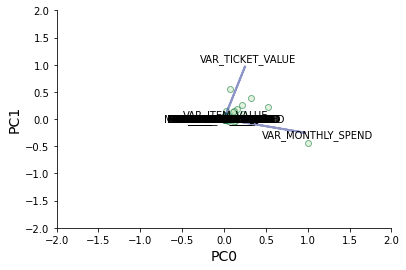

In [10]:
def biplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max()- xs.min())
    scaley = 1.0 / (ys.max()- ys.min())
    plt.scatter(xs * scalex, ys * scaley, color='#c7e9c0', edgecolor='#006d2c', alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='#253494', alpha=0.5, lw=2) 
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, f'Var{str(i + 1)}', color='#000000', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='#000000', ha='center', va='center')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(False)
    # plt.xticks(np.arange(0, 1, 0.5), size=12)
    # plt.yticks(np.arange(-0.75, 1, 0.5), size=12)
    plt.xlabel('PC0', size=14)
    plt.ylabel('PC1', size=14)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

biplot(X_reduced[:, 0:2], np.transpose(pca.components_[0:2, :]), labels=X.columns)

That didnt help us much considering we have so many features in our dataset. Let use some simple code to help us to identify what features are need to maintain that 95% we spoke about earlier.

In [11]:
num_primary_components = pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(num_primary_components)]

initial_feature_names = X.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(num_primary_components)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(num_primary_components)}

# build the dataframe
component_df = pd.DataFrame(dic.items())
print(component_df)

     0                  1
0  PC0  VAR_MONTHLY_SPEND
1  PC1   VAR_TICKET_VALUE


Here we can see that the most influential features in our dataset seem to be the variance in monthly spending of a client along with the variance in ticket total of a client.

#Clustering

Now that we've appropriately reduced our dimensions we can start with clustering. How do we know how many clusters to use before hand ? We don't...However, we can run tests to determine which number of clusters is the optimal amount. Here we will be using the elbow method to get this done.

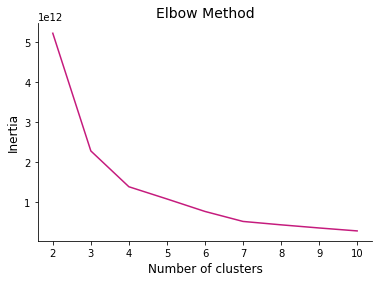

In [12]:
inertia = []

for i in range(2, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = km.fit_predict(X_reduced)
    # Keep data for elbow method optimization
    inertia.append(km.inertia_)

plt.plot(range(2, 11), inertia, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('Inertia', size=12)
plt.show() 



From the graph above we the intertia drops very quickly as we increase k up to 7 but then it increase much slower after that point. From this we can deduce that 7 clusters is most likely our best bet.

Now let's train our final model with these parameters!

In [13]:
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=10, n_init=10, random_state=0)

final_cluster_labels = kmeans.fit_predict(X_reduced)

# Displaying clusters

Now that our model has been train and has predicted the clusters of our data instances lets display them on a graph to gain a clearer understanding.

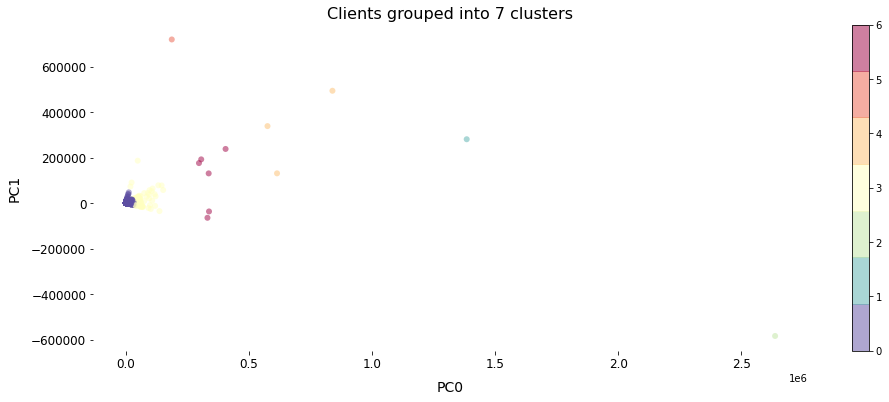

In [14]:
fig, ax = plt.subplots(figsize = (16, 6))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=final_cluster_labels, 
            edgecolor="none", 
            cmap=plt.cm.get_cmap("Spectral_r", 7),
            alpha=0.5)
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("PC0", size = 14, labelpad=10)
plt.ylabel("PC1", size = 14, labelpad=10)

plt.title('Clients grouped into 7 clusters', size=16)


plt.colorbar(ticks=[0, 1, 2, 3, 4, 5, 6]);

plt.show()

Because we used dimensionaity reduction the the PC0 and PC1 no longer mean much to us. To regain some visibility let's idenitfy our cluster centers and reverse the dimension reduction on these points.

In [15]:
centroids_recovered = pca.inverse_transform(kmeans.cluster_centers_)
centroids = pd.DataFrame(
    centroids_recovered,
    columns=[
        'TOTAL_ITEM_QTY',
        'TOTAL_ITEM_VALUE',
        'TOTAL_TICKET_QTY',
        'MEAN_ITEM_VALUE' ,
        'STD_ITEM_VALUE',
        'VAR_ITEM_VALUE',
        'SEM_ITEM_VALUE',
        'MIN_ITEM_VALUE',
        'MAX_ITEM_VALUE',
        'MEAN_MONTHLY_SPEND',
        'STD_MONTHLY_SPEND',
        'VAR_MONTHLY_SPEND',
        'SEM_MONTHLY_SPEND',
        'MIN_MONTHLY_SPEND',
        'MAX_MONTHLY_SPEND',
        'MEAN_MONTHLY_VISIT',
        'STD_MONTHLY_VISIT',
        'VAR_MONTHLY_VISIT',
        'SEM_MONTHLY_VISIT',
        'MIN_MONTHLY_VISIT',
        'MAX_MONTHLY_VISIT',
        'MEAN_TICKET_VALUE',
        'STD_TICKET_VALUE',
        'VAR_TICKET_VALUE',
        'SEM_TICKET_VALUE',
        'MIN_TICKET_VALUE',
        'MAX_TICKET_VALUE',
        'MEAN_TICKET_QTY',
        'STD_TICKET_QTY',
        'VAR_TICKET_QTY',
        'SEM_TICKET_QTY',
        'MIN_TICKET_QTY',
        'MAX_TICKET_QTY',
    ])



centroids.index_name = "ClusterID"
centroids["ClusterID"] = centroids.index
centroids = centroids.reset_index(drop=True)




pd.set_option('display.float_format', str)
print(centroids[['VAR_MONTHLY_SPEND', 'VAR_TICKET_VALUE', 'ClusterID']])
print(type(kmeans.cluster_centers_))

   VAR_MONTHLY_SPEND   VAR_TICKET_VALUE  ClusterID
0  87.93242884278635  63.03049515933092          0
1 1269951.8484338652  618620.5294677002          1
2 2700016.9123336435   97999.6140539592          2
3  57828.39360716145 31533.268025228066          3
4  574148.8752810098 479714.15645509755          4
5  40.70201785394816  741359.1351921166          5
6  298587.2785932645  186411.5156892337          6
<class 'numpy.ndarray'>


# Conclusion
From this experiment we were able to segment a sample of our customer population into 7 groups. We can now use this information to recommend products to our customers and have a more in depth understanding of who they are their behaviours.